# Submodule 4: Comparative genomics analysis
--------
## Overview
In this submodule, you will begin with a directory of proteomes from *de novo* assembled and annotated genomes. A single bacterial genome was analyzed in Submodules 1 & 2 and we automated the process on many genomes in Submodule 3 to produce a total of XX genome sequences. We will add to this dataset with reference genomes publicly available from NCBI. These genome sequences are curated for quality and provide gene accessions with curated functional information. These datasets are crucial for providing context to our new dataset.

Genome assembly is a foundational step that allows researchers to generate a complete picture of the genetic material in a given organism. Assessing the quality and completeness of a genome assembly ensures that it accurately reflects the original genome, providing a reliable foundation for further analysis. Comparative genomics builds on genome assembly by comparing the genomes of different species or individuals. This field focuses on identifying similarities and differences in DNA sequences to understand evolutionary relationships and reveal the genetic underpinnings of adaptation and diversity. Comparative genomics can uncover how species evolve and adapt over time and identify genes associated with specific traits or diseases.

<p align="center">
  <img src="images/toxo_multi_alignment.png" width="80%"/>
</p>

### Learning Objectives

Through this submodule, users will gain experience in comparative genomics, resulting in an understanding of how to use existing genomes a reference points to better understand the context of a novel genome. You will Learn to perform comparative genomic analyses to identify similarities and differences across genomes, run phylogenomic analyses, construct pangenomes to capture genetic diversity. You will then apply these techniques to address biological questions and hypotheses. 

- **Access Genome Datasets from the NCBI**:<br>
  Participants will use command line tools to acces genomes on NCBI for use in comparative genomics analyses.
    
- **Perform and Visualize Comparative Genomics Analyses**:<br>
  Gain proficiency in using comparative genomics tools and visuazing their outputs. Participants will use these outputs to identify patterns across genomes and develop hypotheses about genome relatedness, gene loss or gain events, and gene duplications.

- **Create and Understand Phylogeny Trees**:<br>
  Use both ortholog groups and average nucleotide identity in genes to create phylogeny trees. Use phylogeny trees to gain an understanding of the see species relatedness and to understand taxonomic groupings.

- **Draw Conclusions about Assembled Genome**:<br>
  Using the comparisons to fully annotated genomes, participants should be able to identify patterns in host and strain of comparator genomes and draw their own conclusions about the genomes assembled in submodules 1-3.

## **Install required software**

A few more tools are required for Submodule 4; OrthoFinder, UpSet plot, fastANI, and seaborn. As with submodule 1, we will install these tools using __[Conda](https://docs.conda.io/en/latest/)__.

Each piece of software, along with links to publications and documentation, will be described in turn. Below is a brief summary of these tools.

### List of software
| **Tool**       | **Description**                                                                                                                                                           |
|:---------------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **OrthoFinder**      | Finds orthogroups and orthologs, infers rooted gene trees for all orthogroups and identifies all of the gene duplication events in those gene trees.                         |
| **UpSet Plots**      | UpSet plots are a data visualization method for showing set data with more than three intersecting sets.                                                  |
| **fastANI**        | Developed for fast alignment-free computation of whole-genome Average Nucleotide Identity (ANI). ANI is defined as mean nucleotide identity of orthologous gene pairs shared between two microbial genomes.     
| **seaborn**        | A python library necessary for creating complex heatmaps.   |

In [1]:
%%bash

# other installs are already complete, we just need to install seaborn
mamba install seaborn --quiet

Confirm changes: [Y/n] Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


## Starting Data

This submodule begins with a directory of genomes in FASTA format and a directory of proteomes in FAA (FASTA amino acid) format. This module is designd to work with data produced from submodule 3, but feel free replace the FAA files within the directory *proteomes* or add additional FAA files as neeeded.

In [2]:
%%bash

ls data/proteomes/

MchelAmEel.faa
MchelBovis.faa
MchelHSB.faa
MycoSp10K.faa
MycoSpM7.faa
UnknownMyco3B.faa


In [3]:
%%bash

ls data/genomes/

MchelAmEel.filtered.fasta
MchelBovis.filtered.fasta
MchelHSB.filtered.fasta
MycoSp10K.filtered.fasta
MycoSpM7.filtered.fasta
UnknownMyco3B.filtered.fasta


## Process 1: Downloading Reference Genomes and Proteomes from NCBI
We have a directory of `genomes` and `proteomes` we created in submodules 1-3. To provide these context, we can also access thousands of deposited and annotated bacterial genomes and proteomes from NCBI with a few commands. For comparative genomics, we will grab several genomes in 

In [4]:
%%bash

# download the list of all refseq assemblies
if [[ ! -s assembly_summary_refseq.txt ]]
then
    wget https://ftp.ncbi.nlm.nih.gov/genomes/ASSEMBLY_REPORTS/assembly_summary_refseq.txt -O assembly_summary_refseq.txt --quiet --no-check-certificate
fi

In [8]:
%%bash

species="Campylobacter jejuni"

# we can use grep to search for our target organism
grep "$species" assembly_summary_refseq.txt | head -n 3


GCF_000007865.1	PRJNA224116	SAMN02604086	na	na	262316	1764	Mycobacterium avium subsp. paratuberculosis K-10	strain=K-10	na	latest	Complete Genome	Major	Full	2004-01-30	ASM786v1	Univ. Minnesota	GCA_000007865.1	identical	https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/007/865/GCF_000007865.1_ASM786v1	na	na	na        	haploid	bacteria	4829781	4829781	69.500000	1	1	1	NCBI RefSeq	GCF_000007865.1-RS_2024_03_20	2024-03-20	4571	4288	53	16116077
GCF_000008585.1	PRJNA224116	SAMN02603992	na	na	83331	1773	Mycobacterium tuberculosis CDC1551	strain=CDC1551	na	latest	Complete Genome	Major	Full	2004-08-04	ASM858v1	TIGR	GCA_000008585.1	identical	https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/008/585/GCF_000008585.1_ASM858v1	na	na	na        	haploid	bacteria	4403837	4403837	65.500000	1	1	1	NCBI RefSeq	GCF_000008585.1-RS_2024_06_21	2024-06-21	4154	3871	51	12218036
GCF_000009445.1	PRJNA224116	SAMEA2272684	na	na	410289	1773	Mycobacterium tuberculosis variant bovis BCG str. Pasteur 1173P2	strain=BCG Past

<div class="alert alert-block alert-info"><b>Tip</b>: Click on one of the blue highlighted links above to be taken to an assembly page on NCBIs server. Notice how the assembly page is laid out just like a directory and the link looks like a path. This is just like how our cloud server works!</div>

<p align="center">
  <img src="images/ncbi_screenshot.png" width="80%"/>
</p>

Let's use grep again to search for our organism, but this time we are going to `sort` the results randomly and take the top 10 results. We can then use `cut` to select only the 20th column which contains the link. We will also add an outgroup which should fall outside our other isolates in further analyses. After, we will loop through the links and download them by adding the file we want from the assembly directory to the end of the link.

In [ ]:
%%bash

#cleaning temp, dont leave in
rm query_list.txt reference_list.txt
rm data/*/Campy*

In [9]:
%%bash

species="Campylobacter jejuni"
outgroup="Campylobacter fetus"

links=$(grep "$species" assembly_summary_refseq.txt | sort -R | head -n 10 | cut -f 20)

# adding an outgroup for our analysis
# Add the link for the outgroup (just one for now)
outgroup_link=$(grep "$outgroup" assembly_summary_refseq.txt | sort -R | head -n 1 | cut -f 20)

# Append outgroup link to the species links
links="$links $outgroup_link"


for link in $links
do

    # gets the species corresponding to the isolate
    species=$(grep $link assembly_summary_refseq.txt | cut -f 8 | cut -f 1-2 -d' ' | sed 's/ /_/')
    # gets the accession number from the full link
    accession=$(echo $link | awk -F'/' '{print $NF}')
    
    echo Downloading $species from $(echo $link)

    # gets file names
    genome_file=${accession}_genomic.fna.gz
    proteome_file=${accession}_protein.faa.gz

    # gets fna download link
    fna=${link}/${genome_file}
    faa=${link}/${proteome_file}

    # wget downloads the file
    # -O specifies a name for the output file
    wget $fna -O data/genomes/${species}_${genome_file} --quiet --no-check-certificate
    wget $faa -O data/proteomes/${species}_${proteome_file} --quiet --no-check-certificate

done

In [11]:
%%bash

# lastly, we have to unzip the genome and proteome files
gunzip data/genomes/*.gz
gunzip data/proteomes/*.gz


# echo list the two starting directories
echo '-----------------GENOMES--------------------'
ls data/genomes/
echo '-----------------PROTEOMES------------------'
ls data/proteomes/

gzip: data/genomes/*.gz: No such file or directory
gzip: data/proteomes/*.gz: No such file or directory


-----------------GENOMES--------------------
MchelAmEel.filtered.fasta
MchelBovis.filtered.fasta
MchelHSB.filtered.fasta
MycoSp10K.filtered.fasta
MycoSpM7.filtered.fasta
Mycobacterium_avium_GCF_002292425.1_ASM229242v1_genomic.fna
Mycobacterium_liflandii_GCF_000026445.2_ASM2644v2_genomic.fna
Mycobacterium_marinum_GCF_002911515.1_ASM291151v1_genomic.fna
Mycobacterium_marinum_GCF_003431675.1_ASM343167v1_genomic.fna
Mycobacterium_marinum_GCF_003431805.1_ASM343180v1_genomic.fna
Mycobacterium_marinum_GCF_024341605.1_ASM2434160v1_genomic.fna
Mycobacterium_marinum_GCF_964110065.1_M_marinum_H_9800756_genomic.fna
Mycobacterium_marinum_GCF_964110115.1_M_marinum_mis_14_genomic.fna
Mycobacterium_marinum_GCF_964110335.1_M_marinum_H_2000-01053_genomic.fna
Mycobacterium_marinum_GCF_964110555.1_M_marinum_E12_genomic.fna
Mycobacterium_marinum_GCF_964110575.1_M_marinum_myc_7801_genomic.fna
Mycobacterium_marinum_GCF_964110625.1_M_marinum_H_2001-00458_genomic.fna
Mycobacteroides_chelonae_GCF_001853585.1_AS

We now have 11 genomes and 11 proteomes from NCBI which we can use for comparative genomics! Let's start by comparing our genomes to the NCBI isolates with FastANI.

## Process 2: Comparing Average Nucleotide Identity using FastANI
Program: FastANI - Fast alignment-free computation of whole-genome Average Nucleotide Identity (ANI)
Citation : Jain, C., Rodriguez-R, L.M., Phillippy, A.M. et al. *High throughput ANI analysis of 90K prokaryotic genomes reveals clear species boundaries.* Nat Commun 9, 5114 (2018). https://doi.org/10.1038/s41467-018-07641-9
Manual: https://github.com/ParBLiSS/FastANI

FastANI is developed for fast alignment-free computation of whole-genome Average Nucleotide Identity (ANI). ANI is defined as mean nucleotide identity of orthologous gene pairs shared between two microbial genomes. FastANI supports pairwise comparison of both complete and draft genome assemblies and avoids expensive sequence alignments in most ANI tools. With all our genomes on hand, we can make an initial comparison of ANI to give a preview of potential patterns among our genome set.

In [12]:
%%bash

# take a look at the help menu
fastANI -h

-----------------
fastANI is a fast alignment-free implementation for computing whole-genome Average Nucleotide Identity (ANI) between genomes
-----------------
Example usage:
$ fastANI -q genome1.fa -r genome2.fa -o output.txt
$ fastANI -q genome1.fa --rl genome_list.txt -o output.txt

SYNOPSIS
--------
fastANI [-h] [-r <value>] [--rl <value>] [-q <value>] [--ql <value>] [-k
        <value>] [-t <value>] [--fragLen <value>] [--minFraction <value>]
        [--maxRatioDiff <value>] [--visualize] [--matrix] [-o <value>] [-s] [-v]

OPTIONS
--------
-h, --help
     print this help page

-r, --ref <value>
     reference genome (fasta/fastq)[.gz]

--rl, --refList <value>
     a file containing list of reference genome files, one genome per line

-q, --query <value>
     query genome (fasta/fastq)[.gz]

--ql, --queryList <value>
     a file containing list of query genome files, one genome per line

-k, --kmer <value>
     kmer size <= 16 [default : 16]

-t, --threads <value>
     thread coun

We want to run FastANI with all of our genomes queried against each other. This corresponds to the example in the manual `fastANI --ql [QUERY_LIST] --rl [REFERENCE_LIST] -o [OUTPUT_FILE]`. The query and reference lists are lists of the paths to our genomes. Let's first make these files with some more bash looping.

In [13]:
%%bash

# looping through all genome files in our genome directory
for genome in data/genomes/*
do
    # readlink gets the full path to the genome, tee writes the path to two files at once
    echo $genome | tee -a query_list.txt reference_list.txt
done

data/genomes/MchelAmEel.filtered.fasta
data/genomes/MchelBovis.filtered.fasta
data/genomes/MchelHSB.filtered.fasta
data/genomes/MycoSp10K.filtered.fasta
data/genomes/MycoSpM7.filtered.fasta
data/genomes/Mycobacterium_avium_GCF_002292425.1_ASM229242v1_genomic.fna
data/genomes/Mycobacterium_liflandii_GCF_000026445.2_ASM2644v2_genomic.fna
data/genomes/Mycobacterium_marinum_GCF_002911515.1_ASM291151v1_genomic.fna
data/genomes/Mycobacterium_marinum_GCF_003431675.1_ASM343167v1_genomic.fna
data/genomes/Mycobacterium_marinum_GCF_003431805.1_ASM343180v1_genomic.fna
data/genomes/Mycobacterium_marinum_GCF_024341605.1_ASM2434160v1_genomic.fna
data/genomes/Mycobacterium_marinum_GCF_964110065.1_M_marinum_H_9800756_genomic.fna
data/genomes/Mycobacterium_marinum_GCF_964110115.1_M_marinum_mis_14_genomic.fna
data/genomes/Mycobacterium_marinum_GCF_964110335.1_M_marinum_H_2000-01053_genomic.fna
data/genomes/Mycobacterium_marinum_GCF_964110555.1_M_marinum_E12_genomic.fna
data/genomes/Mycobacterium_marinum_

In [14]:
%%bash

fastANI --ql query_list.txt --rl reference_list.txt -t 24 -o fastani_output.tsv --minFraction 0

>>>>>>>>>>>>>>>>>>
Reference = [data/genomes/MchelAmEel.filtered.fasta, data/genomes/MchelBovis.filtered.fasta, data/genomes/MchelHSB.filtered.fasta, data/genomes/MycoSp10K.filtered.fasta, data/genomes/MycoSpM7.filtered.fasta, data/genomes/Mycobacterium_avium_GCF_002292425.1_ASM229242v1_genomic.fna, data/genomes/Mycobacterium_liflandii_GCF_000026445.2_ASM2644v2_genomic.fna, data/genomes/Mycobacterium_marinum_GCF_002911515.1_ASM291151v1_genomic.fna, data/genomes/Mycobacterium_marinum_GCF_003431675.1_ASM343167v1_genomic.fna, data/genomes/Mycobacterium_marinum_GCF_003431805.1_ASM343180v1_genomic.fna, data/genomes/Mycobacterium_marinum_GCF_024341605.1_ASM2434160v1_genomic.fna, data/genomes/Mycobacterium_marinum_GCF_964110065.1_M_marinum_H_9800756_genomic.fna, data/genomes/Mycobacterium_marinum_GCF_964110115.1_M_marinum_mis_14_genomic.fna, data/genomes/Mycobacterium_marinum_GCF_964110335.1_M_marinum_H_2000-01053_genomic.fna, data/genomes/Mycobacterium_marinum_GCF_964110555.1_M_marinum_E12_g

In [15]:
%%bash

# taking a look at our output
head -n 5 fastani_output.tsv

data/genomes/MchelAmEel.filtered.fasta	data/genomes/MchelAmEel.filtered.fasta	100	1766	1767
data/genomes/MchelAmEel.filtered.fasta	data/genomes/Mycobacteroides_chelonae_GCF_002013455.1_ASM201345v1_genomic.fna	99.821	1618	1767
data/genomes/MchelAmEel.filtered.fasta	data/genomes/Mycobacteroides_chelonae_GCF_002013855.1_ASM201385v1_genomic.fna	99.7425	1630	1767
data/genomes/MchelAmEel.filtered.fasta	data/genomes/Mycobacteroides_chelonae_GCF_001853665.1_ASM185366v1_genomic.fna	99.7388	1644	1767
data/genomes/MchelAmEel.filtered.fasta	data/genomes/Mycobacteroides_chelonae_GCF_021729805.1_ASM2172980v1_genomic.fna	99.7332	1631	1767


### Explanation of FastANI output

FastANI outputs a tab delimited file with a row for every query genome and five columns. The columns correspond to the query genome, the reference genome, ANI value, count of bidirectional fragment mappings, and total query fragments respectively. Since our NCBI genomes are from the same species as our isolate, our ANI value should be >95%.

For some downstream analysis, we should clean these names up a bit. We don't need the preceding data/genomes/ before every one of our genomes. Below, we use `sed` to edit a file in place, replacing all instance of `/data/genomes/` with empty text. More info on `sed` can be found in its manual page [here](https://linux.die.net/man/1/sed).

In [16]:
%%bash

# sed syntax is 's|what we want to find|what we want to replace it with|'
# the -i flag specifies that the operation is in place and won't make a new file
# the g at the end of the sed expression stands for global--replacing every instance in the whole document
sed -i 's|data/genomes/||g' fastani_output.tsv

In [17]:
%%bash

# we should see the effect of sed now
head -n 5 fastani_output.tsv

MchelAmEel.filtered.fasta	MchelAmEel.filtered.fasta	100	1766	1767
MchelAmEel.filtered.fasta	Mycobacteroides_chelonae_GCF_002013455.1_ASM201345v1_genomic.fna	99.821	1618	1767
MchelAmEel.filtered.fasta	Mycobacteroides_chelonae_GCF_002013855.1_ASM201385v1_genomic.fna	99.7425	1630	1767
MchelAmEel.filtered.fasta	Mycobacteroides_chelonae_GCF_001853665.1_ASM185366v1_genomic.fna	99.7388	1644	1767
MchelAmEel.filtered.fasta	Mycobacteroides_chelonae_GCF_021729805.1_ASM2172980v1_genomic.fna	99.7332	1631	1767


In [18]:
%%bash

scripts/fastANI_heatmap.py -h

usage: fastANI_heatmap.py [-h] [--input INPUT] [--out OUT]

Creates a heatmap from fastANI results

options:
  -h, --help            show this help message and exit
  --input INPUT, -i INPUT
                        FastANI results to make a heatmap from
  --out OUT             Name of the resulting heatmap


In [19]:
%%bash

scripts/fastANI_heatmap.py --input fastani_output.tsv --out fastani_heatmap.png

## A Briefer on Phylogeny

<p align="center">
  <img src="images/phylogeny_explanation.png" width="80%"/>
</p>

This image illustrates the concept of phylogenetic trees, which are used to represent evolutionary relationships among species. Each branch point, or node, represents a common ancestor shared by the species that diverge from it. For example, the most recent common ancestor of species A and B is highlighted at the upper node connecting them. Similarly, the root at the base of the tree represents the most recent common ancestor of all the species shown (A, B, C, D, and E). The tree branches from left to right, moving from ancestors to present-day species. In this tree, species E is the outgroup, as it diverged earliest and shares a more distant common ancestor with the other species. Understanding these relationships helps scientists study how species have evolved over time and how they are related.

### Visualizing the ANI cladogram
Running the below cell with display the heatmap from FastANI which also contains a phylogenetic tree or cladogram. What do these results tell us? Is our outgroup the same species or different than the rest of our isolates? Do you see other interesting pattens?

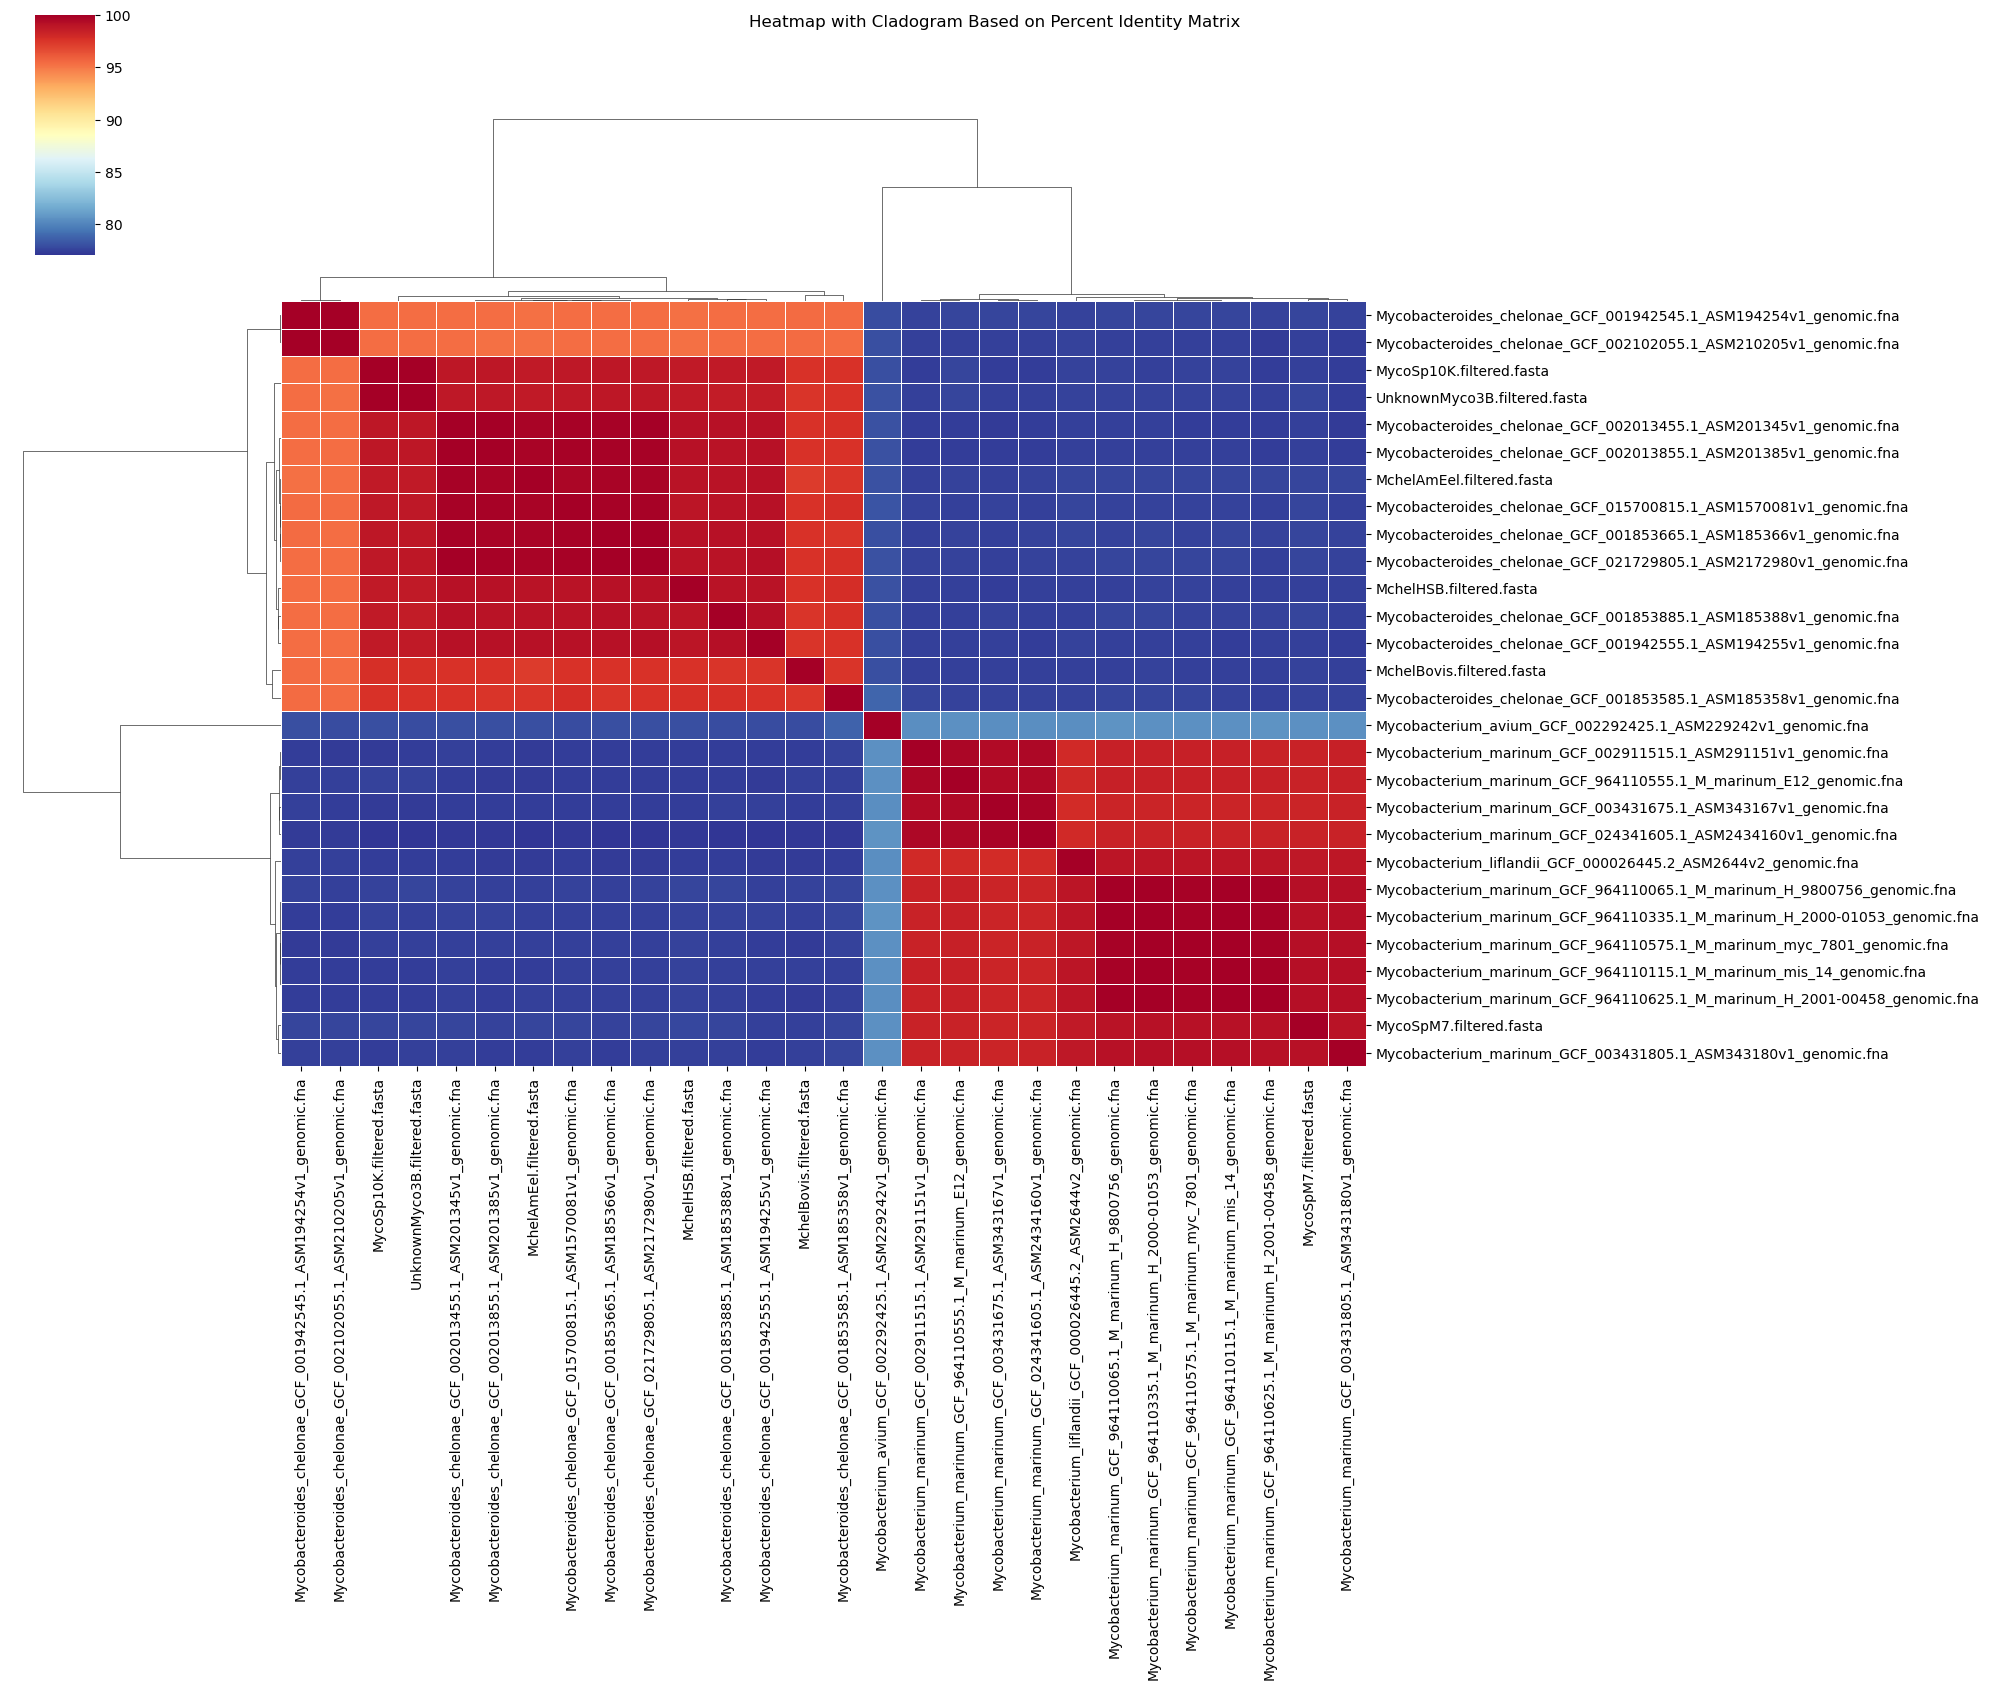

In [20]:
from IPython.display import Image
Image(filename='fastani_heatmap.png')

## Process 3: Orthofinder Pairwise Orthology Analysis
There are many ways to make phylogenetic comparisons. FastANI, as it suggests in the name, is a fast option. However, Average Nucleotide Identity is not the most accurate predictor of phylogeny. For this, we want to turn to ortholog analysis, that is, looking at the shared and unshared genes and their sequences among our isolates. We have a already added sequences from NCBI to our `proteomes` directory. Here, we will use them for comparative genomics analysis with **Orthofinder**. The manual is very detailed, I recommend taking some time to read it.

Orhtofinder Manual: https://github.com/davidemms/OrthoFinder

The program takes a set of protein sequences for each isolate and runs pair-wise comarisons to identify orhtologous groups. For each orthogroup a gene tree is calculated and in the end an overall species tree is computed. To get a meaningful phylogenetic tree we need to be sure to include **at least four different genome datasets**. Ideally we would run this program with all of the avaialble sequences on NCBI. As you can imagine, a pairwise comparison with thousands of Campylobacter genomes would take a long time (days). We will therefore run it with our reduced set.

Start by counting the number of proteins in all the starting files. Think about what these numbers tell us right off the bat.

In [21]:
%%bash

# grep -c will count the occurences of a searched string
grep -c '>' data/proteomes/*.faa

data/proteomes/MchelAmEel.faa:5249
data/proteomes/MchelBovis.faa:5214
data/proteomes/MchelHSB.faa:4855
data/proteomes/MycoSp10K.faa:5047
data/proteomes/MycoSpM7.faa:5498
data/proteomes/Mycobacterium_avium_GCF_002292425.1_ASM229242v1_protein.faa:4910
data/proteomes/Mycobacterium_liflandii_GCF_000026445.2_ASM2644v2_protein.faa:4784
data/proteomes/Mycobacterium_marinum_GCF_002911515.1_ASM291151v1_protein.faa:5450
data/proteomes/Mycobacterium_marinum_GCF_003431675.1_ASM343167v1_protein.faa:4796
data/proteomes/Mycobacterium_marinum_GCF_003431805.1_ASM343180v1_protein.faa:5288
data/proteomes/Mycobacterium_marinum_GCF_024341605.1_ASM2434160v1_protein.faa:4942
data/proteomes/Mycobacterium_marinum_GCF_964110065.1_M_marinum_H_9800756_protein.faa:5317
data/proteomes/Mycobacterium_marinum_GCF_964110115.1_M_marinum_mis_14_protein.faa:5273
data/proteomes/Mycobacterium_marinum_GCF_964110335.1_M_marinum_H_2000-01053_protein.faa:5225
data/proteomes/Mycobacterium_marinum_GCF_964110555.1_M_marinum_E12_pr

In [22]:
%%bash

# as always, we should take a look at the help menu
orthofinder -h


OrthoFinder version 2.5.5 Copyright (C) 2014 David Emms

SIMPLE USAGE:
Run full OrthoFinder analysis on FASTA format proteomes in <dir>
  orthofinder [options] -f <dir>

Add new species in <dir1> to previous run in <dir2> and run new analysis
  orthofinder [options] -f <dir1> -b <dir2>

OPTIONS:
 -t <int>        Number of parallel sequence search threads [Default = 32]
 -a <int>        Number of parallel analysis threads
 -d              Input is DNA sequences
 -M <txt>        Method for gene tree inference. Options 'dendroblast' & 'msa'
                 [Default = dendroblast]
 -S <txt>        Sequence search program [Default = diamond]
                 Options: blast, diamond, diamond_ultra_sens, blast_gz, mmseqs, blast_nucl
 -A <txt>        MSA program, requires '-M msa' [Default = mafft]
                 Options: mafft, muscle
 -T <txt>        Tree inference method, requires '-M msa' [Default = fasttree]
                 Options: fasttree, raxml, raxml-ng, iqtree
 -s <file>       

We want to run Orthofinder with all of our proteomes queried against each other. For orthofinder, this simply requires pointing to the directory that our proteomes our in with `orthofinder -f <dir>`

<div class= "alert alert-block alert-info"><b>Tip</b>: Although there are no standards, in many programs <code>-o</code> is the the flag for an output file or directory, while <code>-t</code> typically corresponds to threads.</div></div>

In [23]:
%%bash

# running orthofinder with thread and parallelization options to speed up analysis
orthofinder -t 24 -a 24 -f data/proteomes/ -o orthofinder-analysis


OrthoFinder version 2.5.5 Copyright (C) 2014 David Emms

2025-01-24 19:08:01 : Starting OrthoFinder 2.5.5
24 thread(s) for highly parallel tasks (BLAST searches etc.)
24 thread(s) for OrthoFinder algorithm

Checking required programs are installed
----------------------------------------
Test can run "mcl -h" - ok
Test can run "fastme -i orthofinder-analysis/Results_Jan24/WorkingDirectory/dependencies/SimpleTest.phy -o orthofinder-analysis/Results_Jan24/WorkingDirectory/dependencies/SimpleTest.tre" - ok

Dividing up work for BLAST for parallel processing
--------------------------------------------------
2025-01-24 19:08:02 : Creating diamond database 1 of 28
2025-01-24 19:08:02 : Creating diamond database 2 of 28
2025-01-24 19:08:02 : Creating diamond database 3 of 28
2025-01-24 19:08:02 : Creating diamond database 4 of 28
2025-01-24 19:08:02 : Creating diamond database 5 of 28
2025-01-24 19:08:02 : Creating diamond database 6 of 28
2025-01-24 19:08:02 : Creating diamond database 7 o

## Examine the output files

I will review some, but not all of the files. The manual goes into extensive detail.

```bash
cd Results*/
ls
```

### * Orthogroups.csv

A **tab** seperated table. Each orthogroup is a raw, each column is a different sample.

The table provides all of the data for orthogroups that are in at least two different samples. If a sample has more than one protein for that particular orthogroup than it will have a comma seperated list for the entry. 

```bash
tabview Orthogroups.csv
```

### * Orthogroups_UnassignedGenes.csv

The same style table. Instead this one contains Orthogroups that are not belonging to an orthogroup, they are unique to a single sample. As you scroll down you should notice the proteins belong to different samples.

```bash
tabview Orthogroups_UnassignedGenes.csv
```

###  * Orthogroups.GeneCount.csv

My favorite 'Orthogroup' Output file. Orthogroups are the rows, columns are gene counts per species. This can be easily parsed to see what orthogroups are specific to waht species. It provides total gene counts for each sample.

```bash
tabview Orthogroups.GeneCount.csv
```

* add annotations from a reference sequence

~/orthogroups_add_annotations.py <reference_faa> Orthogroups.txt  Orthogroups.GeneCount.csv

```bash
orthogroups_add_annotations.py ../GCF_000203835.1_ASM20383v1_protein.faa Orthogroups.txt  Orthogroups.GeneCount.csv | tabview -
```


## Statistics

### * Statistics_Overall.csv

A file containing the overall statistcis for the analysis. Total number of genes in the dataset etc. 

```bash
tabview Statistics_Overall.csv
```

### * Statistics_PerSpecies.csv

In my opinion this is the most important statistics output file. It provides details for each sample. How many genes were speciifc to that sample. If you want to know a quick statistics of how 'differen't your genome is, this is it.

```bash
tabview Statistics_PerSpecies.csv
```

### * WorkingDirectory/

All of the work that external programs like BLAST or DIAMOND. 'ls' this directory. It contains all the results for each pairwise comparison.

### * Orthologues_DATE/

This directory contains a lot of useful data related to the Orthofinder analysis and how they commpute the phylogenetic trees.

#### * Recon_Gene_Trees/

A directory containing inferred trees for every orthogroup.

#### * SpeciesTree_rooted.txt

A rooted-species tree. Orthofinder commputes a root for the tree automatically. You can view this in any tree viewing program like FigTree or TreeView (macs). This file is in newick format. Check it out.

```bash
more Orthologues*/SpeciesTree_rooted.txt
```

## Export the tree file and view.


## Bonus - Figures
```
orthogroups_add_annotations.py ../GCF_000203835.1_ASM20383v1_protein.faa Orthogroups.txt  Orthogroups.GeneCount.csv

orthotools-venn.py Results_*/ PROKKA_*.faa species1.faa species2.faa  venn

orthotools-UpSet.R Results_*/Orthogroups.GeneCount.csv

```

In [ ]:
print("test")

In [ ]:
#install the required packages
import requests
import json
import ipywidgets as widgets
from IPython.display import display
import random
print("done installing required packages")

#install the module quiz_module.py
##from quiz_module import run_quiz
from quiz_module import run_quiz
print("done installing quiz_module")

In [ ]:
#This randomizes the order of the possible answers.
##import_type should be one of two str values: 'json' or 'url'
##import_path here defines the json filepath
run_quiz(import_type="json", import_path="questions/1-1.json", instant_feedback=False, shuffle_questions=False, shuffle_answers=True)

In [ ]:
%%bash

aws s3 cp s3://nh-inbre-genome-sequencing-and-comparative-genomic-analysis/ ./

In [ ]:
# Phylogenetic tree

Phylo
ETE toolkit
ToyTree

https://github.com/etetoolkit/ete

http://etetoolkit.org/ipython_notebook/
 ETE Toolkit - Visualization and analyses using Ipython Notebooks 
The ETE toolkit - Ipython notebook integration

https://toytree.readthedocs.io/en/latest/

#South Dokota is doing one

aws s3 cp s3://PATH 